In [ ]:
# Importing section
!pip install gdown
import pandas as pd
import gdown
import torch.nn.functional as F
import torch
import torch.nn as nn
import numpy as np
import os
import PIL
import pickle
import torchvision
from torchvision.transforms import InterpolationMode
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
from sklearn.metrics import f1_score
%matplotlib inline

In [ ]:
# Dataset downloading
url = 'https://drive.google.com/uc?id=1jOnQ0X1hjNtavigf8SuKTtGSaDix2tKV'
output = 'journey-springfield.zip'
gdown.download(url, output, quiet=False)

In [ ]:
# Dataset unzipping
!unzip -q /kaggle/working/journey-springfield.zip

unzip:  cannot find or open /kaggle/working/journey-springfield.zip, /kaggle/working/journey-springfield.zip.zip or /kaggle/working/journey-springfield.zip.ZIP.


**WORKING WITH DATA (CREATING DATASET/DATALOADER)**

In [ ]:
# Define our own dataset class
class Dataset(Dataset):
    def __init__(self, files, mode):
        self.files = sorted(files)
        self.len = len(self.files)
        self.mode = mode
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len

    def load_img(self, image_path):
        image = Image.open(image_path)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.Resize((224,224), interpolation=InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])


        img = self.load_img(self.files[index])

        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize((224,224), interpolation=InterpolationMode.BICUBIC),
                transforms.RandomHorizontalFlip(),
                transforms.RandomAutocontrast(),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            x = transform(img)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        elif self.mode == 'val':
            x = transform(img)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

        else:
            x = transform(img)
            return x


# Paths to train/test datasets
train_files_path = Path('/kaggle/input/springfield/train/simpsons_dataset')
test_files_path = Path('/kaggle/input/springfield/testset/testset')

# Creating 2 index-connected TRAIN lists (every image path has its label in another list)
train_files = sorted(list(train_files_path.rglob('*.jpg')))
train_labels = [path.parent.name for path in train_files]

# Creating image paths TEST list
test_files = sorted(list(test_files_path.rglob('*.jpg')))

# Split TRAIN data to TRAIN and VAL selection
train, val = train_test_split( train_files, test_size=0.25, stratify=train_labels )

# Making TRAIN DataSet/DataLoader
train_dataset = Dataset( train, 'train' )
train_dataloader = DataLoader( train_dataset, 32, shuffle=True )

# Making VAL DataSet/DataLoader
val_dataset = Dataset( val, 'val' )
val_dataloader = DataLoader(val_dataset, 32, shuffle=False )

# Making TEST DataSet/DataLoader
test_dataset = Dataset( test_files, 'test' )
test_dataloader = DataLoader( test_dataset, 32, shuffle=False )

**VISUALISING OUR DATA**

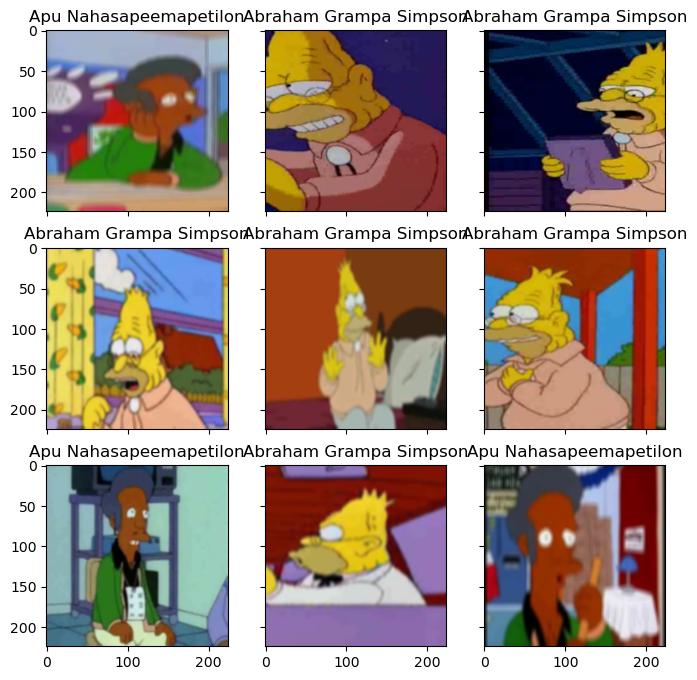

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

**MODEL**

In [ ]:
# Defining pretrened EFFICIENTNET_B2 model + swapping last dense layer + criterion + otimizer
num_classes = 42

model = models.efficientnet_b2(weights='IMAGENET1K_V1')
model.classifier[1] = nn.Linear(1408, 42)


learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

**TRAIN/VAL LOOP**

In [ ]:
device = torch.device("cuda:0")
model = model.to(device)

for epoch in range(10):

    # Train loop
    loss_train_history = 0
    model.train()
    with tqdm(train_dataloader, desc=f"Epoch {epoch+1}") as pbar:
        for i, data in enumerate(pbar):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_train_history += loss.item()

        print(f'Train loss on {epoch+1} epoch is {loss_train_history/len(train_dataloader)}')

    # Eval loop
    model.eval()
    with tqdm(val_dataloader, desc=f"Epoch {epoch+1}") as pbar:
        with torch.no_grad():
            logits = []
            true_logits = []
            for inputs, outputs in pbar:
                inputs = inputs.to(device)
                true_logits += outputs
                preds = model(inputs).cpu()
                logits.append(preds)
        logits = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
        true_logits = [x.item() for x in true_logits]
        pred_logits = np.argmax(logits,-1).tolist()
        score = f1_score(true_logits, pred_logits, average='weighted')
        print(f'Val F1_score on {epoch+1} epoch is {f1_score(true_logits, pred_logits, average="weighted")}')



Epoch 1: 100%|██████████| 491/491 [07:12<00:00,  1.14it/s]


Train loss on 1 epoch is 0.5841018601326374


Epoch 1: 100%|██████████| 164/164 [01:24<00:00,  1.93it/s]


Val F1_score on 1 epoch is 0.9212223976557862


Epoch 2: 100%|██████████| 491/491 [05:38<00:00,  1.45it/s]


Train loss on 2 epoch is 0.22314059236058453


Epoch 2: 100%|██████████| 164/164 [00:55<00:00,  2.95it/s]


Val F1_score on 2 epoch is 0.9509121532718209


Epoch 3: 100%|██████████| 491/491 [05:33<00:00,  1.47it/s]


Train loss on 3 epoch is 0.14190520862375372


Epoch 3: 100%|██████████| 164/164 [00:55<00:00,  2.97it/s]


Val F1_score on 3 epoch is 0.9570981930305732


Epoch 4: 100%|██████████| 491/491 [05:35<00:00,  1.46it/s]


Train loss on 4 epoch is 0.12659073025348563


Epoch 4: 100%|██████████| 164/164 [00:55<00:00,  2.93it/s]


Val F1_score on 4 epoch is 0.9474881162249403


Epoch 5: 100%|██████████| 491/491 [05:34<00:00,  1.47it/s]


Train loss on 5 epoch is 0.1015146242618483


Epoch 5: 100%|██████████| 164/164 [00:51<00:00,  3.16it/s]


Val F1_score on 5 epoch is 0.9627367047856938


Epoch 6: 100%|██████████| 491/491 [05:28<00:00,  1.50it/s]


Train loss on 6 epoch is 0.08164283370218844


Epoch 6: 100%|██████████| 164/164 [00:51<00:00,  3.16it/s]


Val F1_score on 6 epoch is 0.9478926927736017


Epoch 7: 100%|██████████| 491/491 [05:32<00:00,  1.48it/s]


Train loss on 7 epoch is 0.08655708732623787


Epoch 7: 100%|██████████| 164/164 [00:51<00:00,  3.17it/s]


Val F1_score on 7 epoch is 0.9547315906618261


Epoch 8: 100%|██████████| 491/491 [05:37<00:00,  1.46it/s]


Train loss on 8 epoch is 0.07879043837480272


Epoch 8: 100%|██████████| 164/164 [00:55<00:00,  2.93it/s]


Val F1_score on 8 epoch is 0.9502246994017111


Epoch 9: 100%|██████████| 491/491 [05:37<00:00,  1.45it/s]


Train loss on 9 epoch is 0.07111056193790817


Epoch 9: 100%|██████████| 164/164 [00:55<00:00,  2.98it/s]


Val F1_score on 9 epoch is 0.9624370393193089


Epoch 10: 100%|██████████| 491/491 [05:39<00:00,  1.45it/s]


Train loss on 10 epoch is 0.06638900696696162


Epoch 10: 100%|██████████| 164/164 [00:55<00:00,  2.93it/s]


Val F1_score on 10 epoch is 0.9610680898193465


**SAVING TRAINED MODEL**

In [ ]:
torch.save(model.state_dict(), 'model0.96.pth')

**PREDICTION ON TEST DATA**

In [ ]:
with torch.no_grad():
    logits = []
    with tqdm(test_dataloader) as pbar:
        for inputs in pbar:
            inputs = inputs.to(device)
            model.eval()
            preds = model(inputs).cpu()
            logits.append(preds)

[[4.0141244e-13 6.1385318e-17 2.5351417e-20 ... 2.9973748e-14
  1.2594918e-24 1.0470080e-15]
 [1.0938167e-08 1.4253934e-11 1.3986952e-12 ... 1.0242866e-10
  1.4838979e-14 2.4376376e-10]
 [3.3668091e-13 2.5573716e-15 7.7666776e-08 ... 4.2638982e-15
  3.0232103e-15 4.5488175e-12]
 ...
 [7.6461233e-11 4.4831641e-09 3.2488245e-11 ... 5.1838269e-12
  1.4024284e-11 1.0641134e-10]
 [1.1034082e-08 4.8901217e-08 4.0403800e-09 ... 2.9517137e-08
  3.0271178e-11 4.3958997e-07]
 [1.9084766e-07 5.3368143e-10 7.5198948e-08 ... 9.3779623e-11
  8.8516354e-11 1.1454124e-10]]


100%|██████████| 31/31 [00:06<00:00,  4.78it/s]


In [ ]:
# Loading label-encoder
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

# Getting labels from logits
logits = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
pred_logits = np.argmax(logits,-1).tolist()
answer = label_encoder.inverse_transform(pred_logits).tolist()

# Uploading labels to CSV file
test_filenames = [path.name for path in test_files]
submit = pd.DataFrame({'Id': test_filenames, 'Expected': answer})
submit.to_csv('/kaggle/working/submit.csv', index=False)